In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import collections
import os
import shutil
import datetime
import keras_tuner as kt
import visualkeras

from concurrent.futures import ThreadPoolExecutor, as_completed
from PIL import Image, UnidentifiedImageError
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight


In [2]:
dataset_directory = "dataset_livrable_1/"

In [3]:
# def is_image(filename):
#     try:
#         with Image.open(filename) as img:
#             img.verify()
#         return True
#     except (UnidentifiedImageError, OSError):
#         return False

# def move_non_images(directory):
#     dump_directory = "dump"
#     os.makedirs(dump_directory, exist_ok = True)
    
#     for folder, _, files in os.walk(directory):
#         for file in files:
#             file_path = os.path.join(folder, file)
#             if not is_image(file_path):
#                 print(f"Déplacement de {file_path} dans le dossier dump/")
#                 dest_path = os.path.join(dump_directory, file)
#                 try:
#                     shutil.move(file_path, dest_path)
#                 except:
#                     print("Erreur lors du déplacement")
                
# move_non_images(dataset_directory)

In [4]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
image_h = 128
image_w = 128
batch_s = 16

train_set, test_set = keras.utils.image_dataset_from_directory(
    dataset_directory,
    label_mode = "int",
    batch_size = batch_s,
    image_size = (image_h, image_w),
    seed = 42,
    validation_split = 0.3,
    subset = "both"
)

Found 41398 files belonging to 5 classes.
Using 28979 files for training.
Using 12419 files for validation.


In [5]:
class_names = train_set.class_names
print(f"Classes détectées : {class_names}")

Classes détectées : ['Dataset Livrable 1 - Painting', 'Dataset Livrable 1 - Photo', 'Dataset Livrable 1 - Schematics', 'Dataset Livrable 1 - Sketch', 'Dataset Livrable 1 - Text']


In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
validation_size = int(0.3 * len(test_set))

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
validation_set = test_set.take(validation_size).cache().prefetch(buffer_size = AUTOTUNE)
test_set = test_set.skip(validation_size).cache().prefetch(buffer_size = AUTOTUNE)
num_classes = len(class_names)

In [7]:
def ModelTest(*args, **kwargs):
    activation = 'relu'
    model = Sequential(*args, **kwargs)
    model.add(layers.Rescaling(1./255))
    model.add(layers.Conv2D(16, (3, 3), padding = 'same', activation = activation))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(32, (3, 3), padding = 'same', activation = activation))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = activation))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation = activation))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(num_classes, activation = 'softmax'))
    model.summary()
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [8]:
def ModelTest2(*args,**kwargs):
    activation = 'relu'
    model = Sequential(*args, **kwargs)
    model.add(layers.Rescaling(scale = 1./255))
    model.add(layers.Conv2D(32, (3, 3), padding = 'same', activation = activation))
    model.add(layers.ZeroPadding2D(padding = (1, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = activation))
    model.add(layers.ZeroPadding2D(padding = (1, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), padding = 'same', activation = activation))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation = activation))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(num_classes, activation = 'softmax'))
    return model  

In [9]:
modeltest = ModelTest2()
modeltest.summary()
modeltest.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ ?                      │   0 (unbuilt) │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
callbacks = []
tensorboard_callback = TensorBoard(
    log_dir = log_dir,
    histogram_freq = 1
)
checkpoint_callback = ModelCheckpoint(
    filepath = 'checkpoints/best_model_acc.keras',
    monitor = 'val_accuracy',
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    verbose = 1
)
checkpoint_callback_2 = ModelCheckpoint(
    filepath = 'checkpoints/best_model_loss.keras',
    monitor = 'val_loss',
    save_best_only = True,
    save_weights_only = False,
    mode = 'min',
    verbose = 1
)
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 2,
    mode = 'max',
    restore_best_weights = True
)

callbacks.append(early_stopping)
callbacks.append(tensorboard_callback)
callbacks.append(checkpoint_callback)
callbacks.append(checkpoint_callback_2)

In [11]:
y_train = np.array([label.numpy() for _, label in train_set.unbatch()])
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_train), y = y_train)
weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}
def train_model(model, train_set = train_set, test_set = test_set, weights = weights_dict, epochs = 10):

    history = model.fit(
        train_set,
        validation_data = test_set,
        epochs = epochs,
        callbacks = callbacks,
        class_weight = weights
    )
    
    accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    
    epochs_range = range(epochs) if epochs == 10 else range(len(accuracy))
    
    loss = history.history['loss']
    validation_loss = history.history['val_loss']
    
    plt.figure(figsize = (16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label = 'Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title("Training and Validation Accuracy")
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, validation_loss, label = 'Validation Loss')
    plt.legend(loc='upper right')
    plt.title("Training and Validation Loss")
    
    plt.show()

Epoch 1/10
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6125 - loss: 0.8675
Epoch 1: val_accuracy improved from -inf to 0.76988, saving model to checkpoints/best_model_acc.keras

Epoch 1: val_loss improved from inf to 0.48526, saving model to checkpoints/best_model_loss.keras
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 398s 218ms/step - accuracy: 0.6126 - loss: 0.8674 - val_accuracy: 0.7699 - val_loss: 0.4853
Epoch 2/10
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8021 - loss: 0.4140
Epoch 2: val_accuracy improved from 0.76988 to 0.84685, saving model to checkpoints/best_model_acc.keras

Epoch 2: val_loss improved from 0.48526 to 0.39216, saving model to checkpoints/best_model_loss.keras
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 358s 197ms/step - accuracy: 0.8021 - loss: 0.4140 - val_accuracy: 0.8469 - val_loss: 0.3922
Epoch 3/10
1812/1812 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8504 - loss: 0.3210
Epoch 3: val_accuracy improved from 0.84685 to 0.85007, saving model to che

ValueError: x and y must have same first dimension, but have shapes (10,) and (9,)

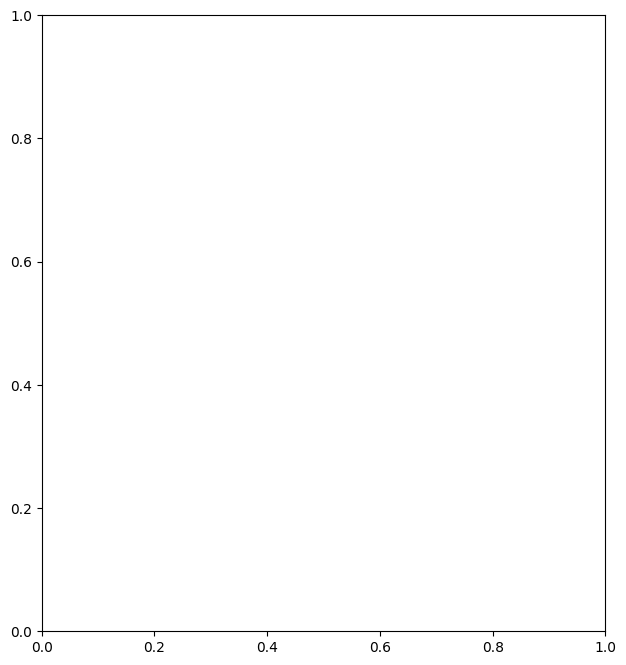

In [12]:
train_model(modeltest, epochs = 10)
modeltest.save('model.keras')


In [23]:
# modeltest.summary()
model = load_model('checkpoints/best_model_loss.keras')

In [24]:

X_test = []
y_true = []

for images, labels in validation_set:
    X_test.append(images)
    y_true.append(labels)

X_test = np.concatenate(X_test)
y_true = np.concatenate(y_true)
def display_matrix(model, X_test = X_test, y_true = y_true, class_names = class_names):
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis = 1)
    cm = confusion_matrix(y_true, y_pred)
    display = ConfusionMatrixDisplay(cm, display_labels = class_names)
    display.plot(cmap = plt.cm.Blues)
    plt.title("Matrice de confusion")
    plt.xticks(rotation = 45)
    plt.show()

117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step


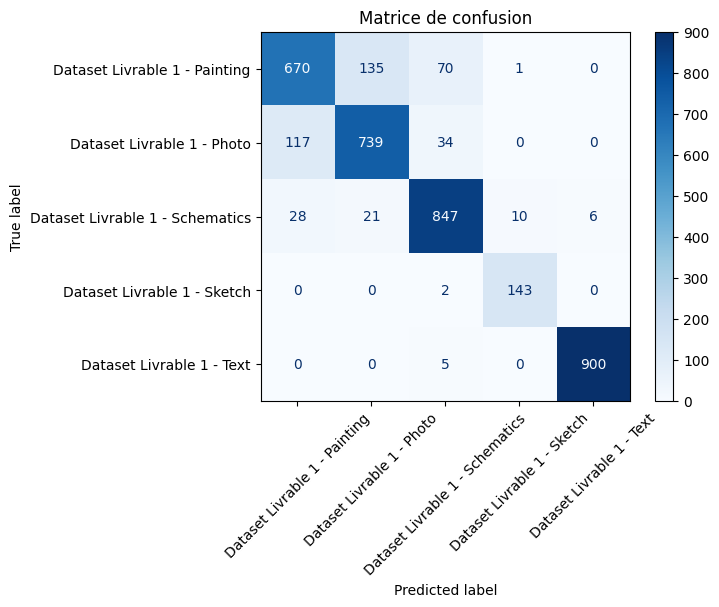

c:\Users\Lucien\Projects\data-science\.venv\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


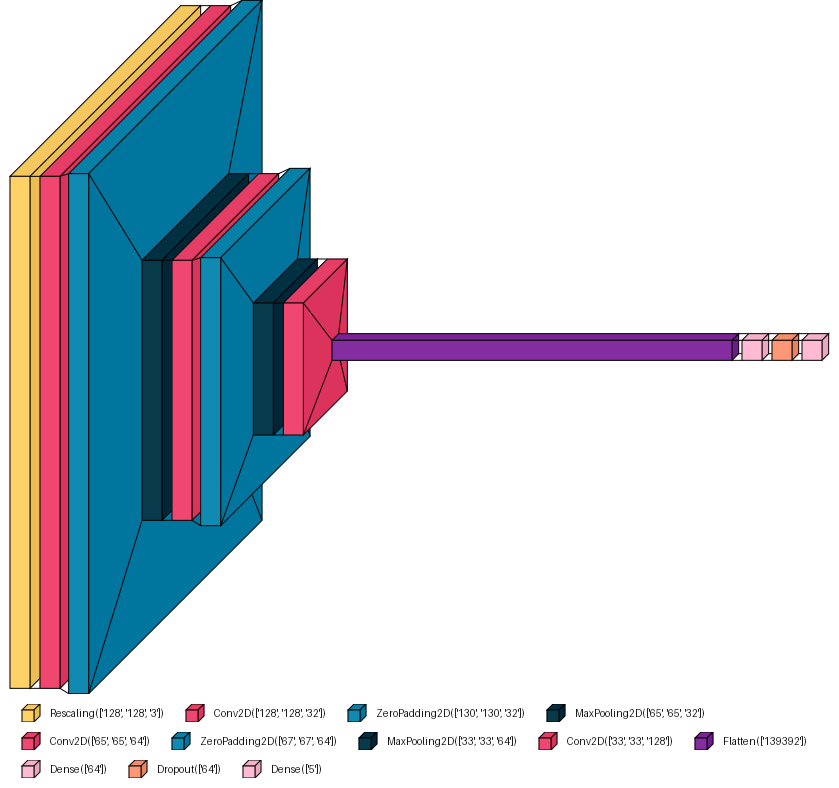

In [25]:
display_matrix(model, X_test, y_true, class_names)
visualkeras.layered_view(
    model,
    legend = True,
    show_dimension = True,
)

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 130, 130, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 65, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 65, 65, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 67, 67, 64)     │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 33, 33, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 33, 33, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 139392)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     8,921,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,044,177 (103.17 MB)

 Trainable params: 9,014,725 (34.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,029,452 (68.78 MB)

Text(0.5, 1.0, 'Training and Validation Loss')

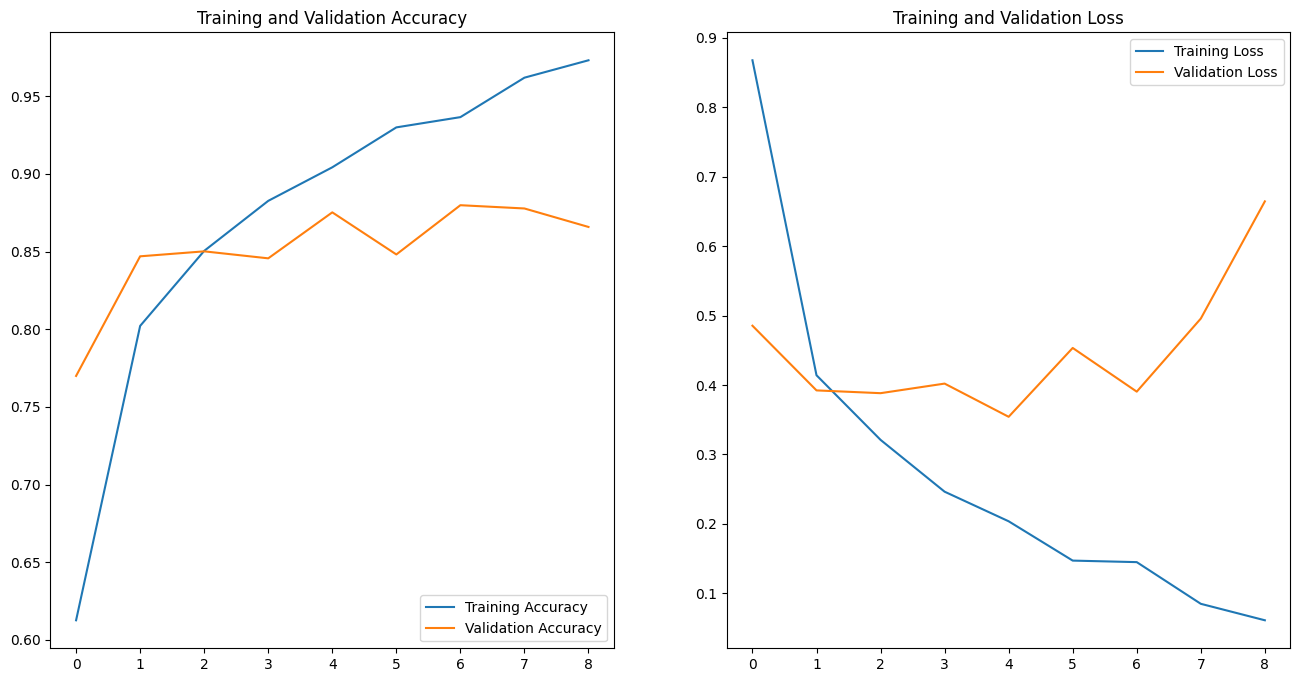

In [27]:
acc = [
  0.6126
  ,0.8021
  ,0.8504
  ,0.8826
  ,0.9042
  ,0.9299
  ,0.9365
  ,0.9619
  ,0.9731
]

loss = [
  0.8674
  ,0.4140
  ,0.3210
  ,0.2464
  ,0.2038
  ,0.1472
  ,0.1450
  ,0.0850
  ,0.0613
]

val_acc = [
  0.7699,
  0.8469,
  0.8501,
  0.8456,
  0.8752,
  0.8481,
  0.8798,
  0.8777,
  0.8658
]

val_loss = [
  0.4853,
  0.3922,
  0.3882,
  0.4020,
  0.3542,
  0.4533,
  0.3904,
  0.4956,
  0.6643
]
epochs_range = range(len(acc))
plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")